In [13]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier # ml - dataframe

from pyspark.mllib.evaluation import BinaryClassificationMetrics # mllib - rdd
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [14]:
spark = SparkSession.builder.appName("Classification with Spark").getOrCreate()

In [15]:
dataset = spark.read.csv("diabetes.csv",header=True)

In [8]:
dataset.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|  31|                   0.248| 26|      1|


In [9]:
dataset.printSchema()

root
 |-- Pregnancies: string (nullable = true)
 |-- Glucose: string (nullable = true)
 |-- BloodPressure: string (nullable = true)
 |-- SkinThickness: string (nullable = true)
 |-- Insulin: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- DiabetesPedigreeFunction: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Outcome: string (nullable = true)



In [10]:
from pyspark.sql.functions import col
new_data = dataset.select(*(col(c).cast("float").alias(c) for c in dataset.columns))

In [11]:
new_data.printSchema()

root
 |-- Pregnancies: float (nullable = true)
 |-- Glucose: float (nullable = true)
 |-- BloodPressure: float (nullable = true)
 |-- SkinThickness: float (nullable = true)
 |-- Insulin: float (nullable = true)
 |-- BMI: float (nullable = true)
 |-- DiabetesPedigreeFunction: float (nullable = true)
 |-- Age: float (nullable = true)
 |-- Outcome: float (nullable = true)



In [12]:
from pyspark.sql.functions import col, count, isnan, when
#checking for null ir nan type values in our columns
new_data.select([count(when(col(c).isNull(), c)).alias(c) for c in new_data.columns]).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [21]:
cols=new_data.columns
cols.remove("Outcome")
assembler = VectorAssembler(inputCols=cols,outputCol="features")
# because in pyspark ml algo , it takes input as vectors or features
# Now let us use the transform method to transform our dataset
data=assembler.transform(new_data)

data.select("features",'Outcome').show(truncate=False) # list of features

+-----------------------------------------------------------------------+-------+
|features                                                               |Outcome|
+-----------------------------------------------------------------------+-------+
|[6.0,148.0,72.0,35.0,0.0,33.599998474121094,0.6269999742507935,50.0]   |1.0    |
|[1.0,85.0,66.0,29.0,0.0,26.600000381469727,0.35100001096725464,31.0]   |0.0    |
|[8.0,183.0,64.0,0.0,0.0,23.299999237060547,0.671999990940094,32.0]     |1.0    |
|[1.0,89.0,66.0,23.0,94.0,28.100000381469727,0.16699999570846558,21.0]  |0.0    |
|[0.0,137.0,40.0,35.0,168.0,43.099998474121094,2.2880001068115234,33.0] |1.0    |
|[5.0,116.0,74.0,0.0,0.0,25.600000381469727,0.20100000500679016,30.0]   |0.0    |
|[3.0,78.0,50.0,32.0,88.0,31.0,0.24799999594688416,26.0]                |1.0    |
|[10.0,115.0,0.0,0.0,0.0,35.29999923706055,0.1340000033378601,29.0]     |0.0    |
|[2.0,197.0,70.0,45.0,543.0,30.5,0.15800000727176666,53.0]              |1.0    |
|[8.0,125.0,96.0

In [22]:
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
data=standardscaler.fit(data).transform(data)

In [23]:
data.select("features",'Outcome','Scaled_features').show(truncate=False)

+-----------------------------------------------------------------------+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                               |Outcome|Scaled_features                                                                                                                                          |
+-----------------------------------------------------------------------+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|[6.0,148.0,72.0,35.0,0.0,33.599998474121094,0.6269999742507935,50.0]   |1.0    |[1.7806383732194306,4.628960915766174,3.7198138711154307,2.1940523222807116,0.0,4.261709202425419,1.8923810993699686,4.251616970894646]                  |
|[1.0,85.0,66.0,29.0,0.0,26.600000381469727,0.3510000109

In [24]:
assembled_data = data.select("Scaled_features","Outcome")
assembled_data.show()

+--------------------+-------+
|     Scaled_features|Outcome|
+--------------------+-------+
|[1.78063837321943...|    1.0|
|[0.29677306220323...|    0.0|
|[2.37418449762590...|    1.0|
|[0.29677306220323...|    0.0|
|[0.0,4.2849165233...|    1.0|
|[1.48386531101619...|    0.0|
|[0.89031918660971...|    1.0|
|[2.96773062203238...|    0.0|
|[0.59354612440647...|    1.0|
|[2.37418449762590...|    1.0|
|[1.18709224881295...|    0.0|
|[2.96773062203238...|    1.0|
|[2.96773062203238...|    0.0|
|[0.29677306220323...|    1.0|
|[1.48386531101619...|    1.0|
|[2.07741143542266...|    1.0|
|[0.0,3.6906580274...|    1.0|
|[2.07741143542266...|    1.0|
|[0.29677306220323...|    0.0|
|[0.29677306220323...|    1.0|
+--------------------+-------+
only showing top 20 rows



In [25]:
train, test = assembled_data.randomSplit([0.7, 0.3])

In [26]:
train.show()

+--------------------+-------+
|     Scaled_features|Outcome|
+--------------------+-------+
|(8,[0,1,6,7],[0.5...|    0.0|
|(8,[0,1,6,7],[0.8...|    0.0|
|(8,[0,1,6,7],[2.0...|    0.0|
|(8,[0,1,6,7],[2.9...|    1.0|
|(8,[1,5,6,7],[2.2...|    0.0|
|(8,[1,5,6,7],[3.0...|    0.0|
|(8,[1,5,6,7],[3.6...|    0.0|
|(8,[1,5,6,7],[4.4...|    1.0|
|(8,[1,5,6,7],[4.5...|    1.0|
|(8,[1,5,6,7],[5.2...|    1.0|
|(8,[1,6,7],[2.940...|    0.0|
|[0.0,2.6898016132...|    0.0|
|[0.0,2.8461854279...|    0.0|
|[0.0,2.9087389538...|    0.0|
|[0.0,2.9087389538...|    0.0|
|[0.0,2.9087389538...|    0.0|
|[0.0,2.9400157167...|    0.0|
|[0.0,2.9712924797...|    0.0|
|[0.0,2.9712924797...|    0.0|
|[0.0,2.9712924797...|    1.0|
+--------------------+-------+
only showing top 20 rows



In [27]:
test.show()

+--------------------+-------+
|     Scaled_features|Outcome|
+--------------------+-------+
|(8,[0,1,6,7],[0.5...|    0.0|
|(8,[0,1,6,7],[1.7...|    0.0|
|(8,[1,5,6,7],[3.7...|    1.0|
|(8,[1,5,6,7],[4.0...|    1.0|
|(8,[1,5,6,7],[4.3...|    1.0|
|[0.0,1.7827754878...|    0.0|
|[0.0,2.0955431172...|    0.0|
|[0.0,2.3144804578...|    0.0|
|[0.0,2.4395875096...|    0.0|
|[0.0,2.6272480873...|    0.0|
|[0.0,2.6272480873...|    0.0|
|[0.0,2.8461854279...|    0.0|
|[0.0,3.1589530573...|    0.0|
|[0.0,3.2527833462...|    0.0|
|[0.0,3.3466136350...|    0.0|
|[0.0,3.5655509756...|    0.0|
|[0.0,3.6593812644...|    0.0|
|[0.0,3.7844883162...|    1.0|
|[0.0,3.8470418421...|    1.0|
|[0.0,3.8783186051...|    0.0|
+--------------------+-------+
only showing top 20 rows



## Logistic Regression

In [56]:
log_reg = LogisticRegression(labelCol="Outcome", featuresCol="Scaled_features",maxIter=40) #max no of iteration model
model=log_reg.fit(train)                                                              #should go to minimize the loss

In [57]:
prediction_test=model.transform(test)

In [58]:
prediction_test.show() # on the basis of prob and thresold it calculates the prediction

+--------------------+-------+--------------------+--------------------+----------+
|     Scaled_features|Outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(8,[0,1,6,7],[0.5...|    0.0|[4.91809522679584...|[0.99274004510815...|       0.0|
|(8,[0,1,6,7],[1.7...|    0.0|[3.11914148529300...|[0.95767544348934...|       0.0|
|(8,[1,5,6,7],[3.7...|    1.0|[1.07362137824220...|[0.74528499159925...|       0.0|
|(8,[1,5,6,7],[4.0...|    1.0|[-0.2794838452623...|[0.43058032281107...|       1.0|
|(8,[1,5,6,7],[4.3...|    1.0|[-0.3863589587755...|[0.40459411366801...|       1.0|
|[0.0,1.7827754878...|    0.0|[3.21915095236868...|[0.96154863508013...|       0.0|
|[0.0,2.0955431172...|    0.0|[1.89433682742308...|[0.86924922254259...|       0.0|
|[0.0,2.3144804578...|    0.0|[3.20156971917916...|[0.96089330580045...|       0.0|
|[0.0,2.4395875096...|    0.0|[2.44283496410001...|[0.92003590419602...|    

In [59]:
prediction_test.select("Outcome","prediction").show(10)

+-------+----------+
|Outcome|prediction|
+-------+----------+
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    1.0|       1.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
+-------+----------+
only showing top 10 rows



In [60]:
# there is no evaluation metric like roc score on ml package 
# so we convert our prediction to rdd so that mllib package has these evaluation metrics
# Compute raw scores on the test set
predictionAndLabels = prediction_test.select("Outcome","prediction").rdd

In [61]:
predictionAndLabels.collect()

[Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=1.0, prediction=0.0),
 Row(Outcome=1.0, prediction=1.0),
 Row(Outcome=1.0, prediction=1.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=1.0, prediction=0.0),
 Row(Outcome=1.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=1.0),
 Row(Outcome=0.0, prediction=1.0),
 Row(Outcome=1.0, pr

In [62]:
metrics = BinaryClassificationMetrics(predictionAndLabels) # this is from mllib package 

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.7681433800328159


In [63]:
evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy_LR = evaluator.evaluate(prediction_test) # ml package 
print ("Accuracy = " ,accuracy_LR)

Accuracy =  0.7959183673469388


In [67]:
model.summary.roc.select('FPR').collect()
model.summary.roc.select('TPR').collect()

[Row(TPR=0.0),
 Row(TPR=0.01951219512195122),
 Row(TPR=0.03902439024390244),
 Row(TPR=0.04878048780487805),
 Row(TPR=0.07317073170731707),
 Row(TPR=0.0975609756097561),
 Row(TPR=0.11219512195121951),
 Row(TPR=0.13658536585365855),
 Row(TPR=0.15609756097560976),
 Row(TPR=0.18048780487804877),
 Row(TPR=0.2048780487804878),
 Row(TPR=0.21951219512195122),
 Row(TPR=0.24390243902439024),
 Row(TPR=0.25853658536585367),
 Row(TPR=0.2780487804878049),
 Row(TPR=0.3024390243902439),
 Row(TPR=0.3170731707317073),
 Row(TPR=0.33170731707317075),
 Row(TPR=0.35121951219512193),
 Row(TPR=0.36585365853658536),
 Row(TPR=0.3853658536585366),
 Row(TPR=0.4097560975609756),
 Row(TPR=0.4195121951219512),
 Row(TPR=0.4292682926829268),
 Row(TPR=0.44878048780487806),
 Row(TPR=0.4634146341463415),
 Row(TPR=0.47804878048780486),
 Row(TPR=0.4926829268292683),
 Row(TPR=0.5073170731707317),
 Row(TPR=0.5170731707317073),
 Row(TPR=0.5365853658536586),
 Row(TPR=0.551219512195122),
 Row(TPR=0.5658536585365853),
 Row(TPR=0

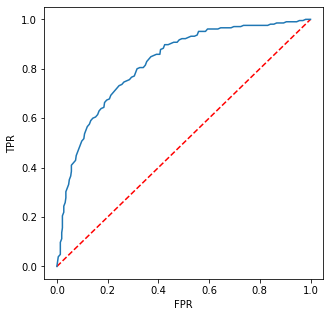

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() # we can manually plot it 

## NaiveBayes

In [46]:
naive_bayes = NaiveBayes(featuresCol='Scaled_features',labelCol='Outcome',smoothing=1.0) 
# smooth our categorical data , it is used to solve the problem of zero probabilities, we assign 1 to get rid of 
# this problem, we're adding 1 to every features

In [47]:
model = naive_bayes.fit(train) 

In [48]:
# select example rows to display.
prediction_test = model.transform(test)

In [49]:
prediction_test.show()

+--------------------+-------+--------------------+--------------------+----------+
|     Scaled_features|Outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(8,[0,1,6,7],[0.5...|    0.0|[-10.275590918844...|[0.58844189772916...|       0.0|
|(8,[0,1,6,7],[1.7...|    0.0|[-17.070740025279...|[0.51972849565021...|       0.0|
|(8,[1,5,6,7],[3.7...|    1.0|[-17.734883792692...|[0.62926711279794...|       0.0|
|(8,[1,5,6,7],[4.0...|    1.0|[-21.753800990343...|[0.63496733651500...|       0.0|
|(8,[1,5,6,7],[4.3...|    1.0|[-25.755342309217...|[0.61375399797293...|       0.0|
|[0.0,1.7827754878...|    0.0|[-29.046016228228...|[0.73088303300680...|       0.0|
|[0.0,2.0955431172...|    0.0|[-27.874409207263...|[0.76893441521258...|       0.0|
|[0.0,2.3144804578...|    0.0|[-22.274861152801...|[0.69912158964023...|       0.0|
|[0.0,2.4395875096...|    0.0|[-31.634238518714...|[0.75220468397624...|    

In [50]:
prediction_test.select("Outcome","prediction").show(10)

+-------+----------+
|Outcome|prediction|
+-------+----------+
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    1.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
+-------+----------+
only showing top 10 rows



In [51]:
predictionAndLabels = prediction_test.select("Outcome","prediction").rdd

In [52]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy_NB = evaluator.evaluate(prediction_test)

In [53]:
print ("Accuracy",accuracy_NB)

Accuracy 0.6938775510204082


In [54]:
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.7037037037037037


## GBTClassifier

In [33]:
gradient_boost_class = GBTClassifier(labelCol="Outcome", featuresCol="Scaled_features")

In [34]:
model = gradient_boost_class.fit(train)

In [35]:
prediction_test = model.transform(test)

In [36]:
prediction_test.show()

+--------------------+-------+--------------------+--------------------+----------+
|     Scaled_features|Outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(8,[0,1,6,7],[0.5...|    0.0|[1.46322164565646...|[0.94913824957671...|       0.0|
|(8,[0,1,6,7],[0.8...|    0.0|[1.41442439862358...|[0.94421499572513...|       0.0|
|(8,[0,1,6,7],[2.0...|    0.0|[0.86062494424491...|[0.84828975982942...|       0.0|
|(8,[1,5,6,7],[3.6...|    0.0|[-0.4109641807414...|[0.30535447566236...|       1.0|
|(8,[1,5,6,7],[4.5...|    1.0|[-1.2122751218803...|[0.08131967312938...|       1.0|
|[0.0,1.7827754878...|    0.0|[1.47520326303112...|[0.95028269848120...|       0.0|
|[0.0,2.4395875096...|    0.0|[1.54494326110814...|[0.95647364100333...|       0.0|
|[0.0,2.9087389538...|    0.0|[1.39984530324886...|[0.94265910276951...|       0.0|
|[0.0,2.9712924797...|    0.0|[1.38329894041672...|[0.94084391976431...|    

In [37]:
prediction_test.select("Outcome","prediction").show(10)

+-------+----------+
|Outcome|prediction|
+-------+----------+
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       1.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
+-------+----------+
only showing top 10 rows



In [38]:
predictionAndLabels = prediction_test.select("Outcome","prediction").rdd

In [39]:
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.6698850574712645


In [40]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator( labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy_GBT = evaluator.evaluate(prediction_test)

In [41]:
print ("Accuracy",accuracy_GBT)

Accuracy 0.7090909090909091


## RandomForestClassifier

In [42]:
random_forest_classifier = RandomForestClassifier(labelCol="Outcome", featuresCol="Scaled_features", numTrees=40)

In [43]:
model = random_forest_classifier.fit(train)

In [44]:
prediction_test = model.transform(test)

In [45]:
prediction_test.show()

+--------------------+-------+--------------------+--------------------+----------+
|     Scaled_features|Outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(8,[0,1,6,7],[0.5...|    0.0|[37.9021449721527...|[0.94755362430381...|       0.0|
|(8,[0,1,6,7],[0.8...|    0.0|[37.4887717197004...|[0.93721929299251...|       0.0|
|(8,[0,1,6,7],[2.0...|    0.0|[26.4189133710575...|[0.66047283427643...|       0.0|
|(8,[1,5,6,7],[3.6...|    0.0|[22.2501223764016...|[0.55625305941004...|       0.0|
|(8,[1,5,6,7],[4.5...|    1.0|[11.1163627511122...|[0.27790906877780...|       1.0|
|[0.0,1.7827754878...|    0.0|[33.6997398322376...|[0.84249349580594...|       0.0|
|[0.0,2.4395875096...|    0.0|[34.8002418249956...|[0.87000604562489...|       0.0|
|[0.0,2.9087389538...|    0.0|[34.1716924620991...|[0.85429231155247...|       0.0|
|[0.0,2.9712924797...|    0.0|[29.9264290075242...|[0.74816072518810...|    

In [46]:
prediction_test.select("Outcome","prediction").show(10)

+-------+----------+
|Outcome|prediction|
+-------+----------+
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
+-------+----------+
only showing top 10 rows



In [47]:
predictionAndLabels = prediction_test.select("Outcome","prediction").rdd

In [48]:
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.7186104218362283


In [49]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator( labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy_RF= evaluator.evaluate(prediction_test)

In [50]:
print ("Accuracy",accuracy_RF)

Accuracy 0.7545454545454545


In [51]:
print("Accuracy of GBT : ",accuracy_GBT)
print("Accuracy of LR : ",accuracy_LR)
print("Accuracy of NB : ",accuracy_NB)
print("Accuracy of RF : ",accuracy_RF)



Accuracy of GBT :  0.7090909090909091
Accuracy of LR :  0.7681818181818182
Accuracy of NB :  0.6863636363636364
Accuracy of RF :  0.7545454545454545
